In [1]:
import os 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'c:\\TCGA-LIHC'

Data Loading

In [3]:
expr_data = pd.read_table("./gene_expression")
gene_list = expr_data['sample']
expr = expr_data.drop(['sample'],axis=1)
expr = expr.transpose()

clinical_data = pd.read_table("./TCGA.LIHC.sampleMap_LIHC_clinicalMatrix")
idx = []
for sample in expr.index:
    sampleID_list = clinical_data['sampleID'].tolist()
    tmp = sampleID_list.index(sample)
    idx.append(tmp)

clinical_core = clinical_data.reindex(idx)
map_dict = {'Primary Tumor' : 1,
            'Recurrent Tumor' : 1,
            'Solid Tissue Normal' : 0}
clinical_core = clinical_core['sample_type'].apply(lambda x : map_dict[x])

Support Vector Machine

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

In [5]:
X = expr
y = clinical_core

In [6]:
svm_acc,svm_f1 = [], []
for i in range(100):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=i)
    clf  = make_pipeline(StandardScaler(), SVC(gamma= 'auto'))
    clf.fit(train_X, train_y)
    
    predict = clf.predict(test_X)
    
    svm_acc.append(float(accuracy_score(test_y, predict)))
    svm_f1.append(float(f1_score(test_y, predict, average = 'macro')))
    
print(f"Average of svm_acc : {sum(svm_acc)/len(svm_acc)}")
print(f"Average of svm_f1 : {sum(svm_f1)/len(svm_f1)}")

Average of svm_acc : 0.9872440944881906
Average of svm_f1 : 0.9697034755446124


In [7]:
data = [svm_acc, svm_f1]
# plt.boxplot(data)
# plt.show

Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
X = expr
y = clinical_core

In [10]:
rf_acc, rf_f1 = [], []

for i in range(100):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=i)
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0)
    clf.fit(train_X, train_y)

    predict = clf.predict(test_X)
    
    rf_acc.append(float(accuracy_score(test_y, predict)))
    rf_f1.append(float(f1_score(test_y, predict, average = 'macro')))
    
print(f"Average of rf_acc : {sum(rf_acc)/len(rf_acc)}")
print(f"Average of rf_f1 : {sum(rf_f1)/len(rf_f1)}")

Average of rf_acc : 0.9799212598425201
Average of rf_f1 : 0.9518143091304492


In [12]:
data.append(rf_acc)
data.append(rf_f1)

# plt.boxplot(data)
# plt.show

Neural Network

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda


X = torch.tensor(expr.to_numpy(), dtype=torch.float)
y = torch.tensor(clinical_core.to_numpy(), dtype=torch.long)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

class TrainDataset(Dataset):
    def __init__(self):
        self.x_data = train_X
        self.y_data = train_y
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x_data[index]).clone().detach()
        y = torch.tensor(self.y_data[index]).clone().detach()
        return x, y
    
class TestDataset(Dataset):
    def __init__(self):
        self.x_data = test_X
        self.y_data = test_y
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x_data[index]).clone().detach()
        y = torch.tensor(self.y_data[index]).clone().detach()
        return x, y
    
training_data = TrainDataset()
test_data = TestDataset()

train_dataloader = DataLoader(training_data, batch_size = 64)
test_dataloader = DataLoader(test_data, batch_size = 64)



class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(20530, 1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,2),
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

learning_rate = 2e-5
batch_size = 64
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

nn_acc = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()   # bc/ gradients by default add up; to prevent double counting.
        loss.backward() # deposits gradients
        optimizer.step()    # adjust parameters with gradients

        # if batch % 100 == 0:
            # loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# iterate over test dataset to check model performance
def test_loop(dataloader, model, loss_fn, t):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    if (t == epochs - 1):
        nn_acc.append(float(correct))

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
for i in range(100):
    # print(f"Num {i+1}\n==============================")
    model = NeuralNetwork()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=i)
    
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn, t)

In [20]:
print(f"Average of nn_acc : {sum(nn_acc)/len(nn_acc)}")

Average of nn_acc : 0.9834645669291352


In [16]:
data.append(nn_acc)

# plt.boxplot(nn_acc)
# plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

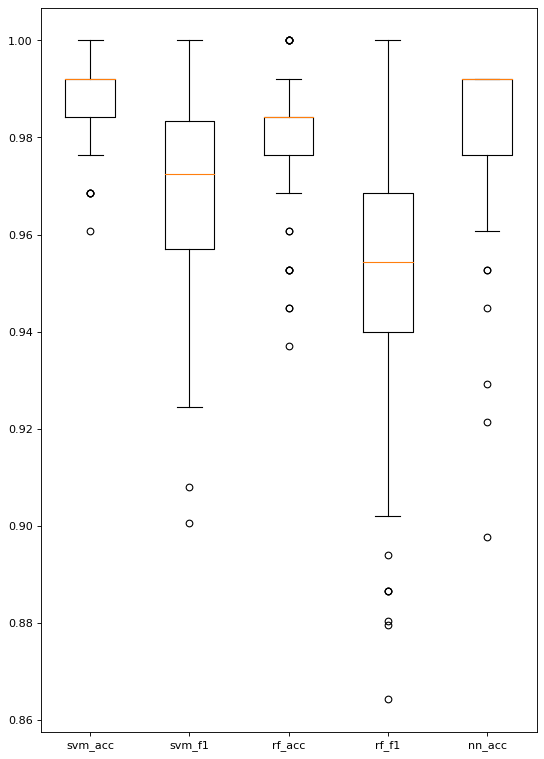

In [19]:
from matplotlib.pyplot import figure

figure(figsize=(8, 12), dpi=80)

plt.boxplot(data, labels= ['svm_acc', 'svm_f1', 'rf_acc', 'rf_f1', 'nn_acc'])

plt.show